In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsy
import os.path
from os.path import exists
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
PATH = "cats_and_dogs"
TRAIN = "train"
TEST = "test"
VAL = "validation"

BATCH_SIZE = 128
EPOCHS = 1000
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
if not exists(PATH):
  !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
  !unzip cats_and_dogs.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOS

In [5]:
train_dir = os.path.join(PATH, TRAIN)
validation_dir = os.path.join(PATH, VAL)
test_dir = os.path.join(PATH, TEST)

In [6]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

In [7]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        batch_size=BATCH_SIZE,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
        '/content/cats_and_dogs', 
        classes=[TEST],
        batch_size=BATCH_SIZE,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


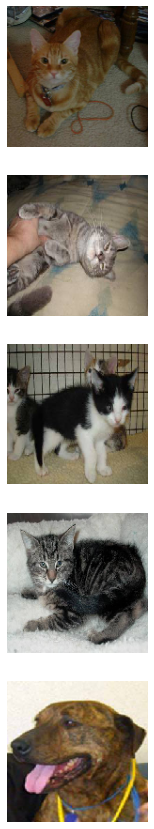

In [8]:
def img_plot(images_array, prob = False):
  fig, axes = plt.subplots(5, 1, figsize=(5, len(images_array) * 3))

  if prob is False:
    for img, ax in zip(images_array, axes):
      ax.imshow(img)
      ax.axis("off")
  else:
    for img, probability, ax in zip(images_array, prob, axes):
      ax.imshow(img)
      ax.axis("off")
      if probability > 0.5: 
        ax.set_title(f"{probability*100:2.f} dog")
      else:
        ax.set_title(f"{(1-probability)*100:2.f} cat")
  plt.show()

sample_train, _ = next(train_data_gen)
img_plot(sample_train[:5])


In [9]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    rotation_range = 15)

Found 2000 images belonging to 2 classes.


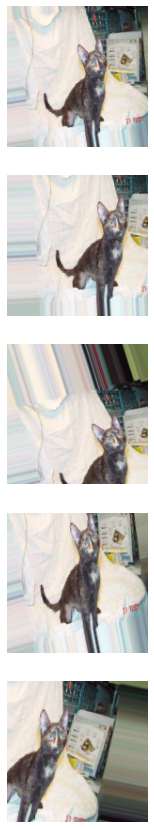

In [10]:
train_data_gen = data_gen.flow_from_directory(
    train_dir, 
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary")

augmented_imgs = [train_data_gen[0][0][0] for i in range(5)]
img_plot(augmented_imgs)

In [11]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)), 
    Dropout(0.2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="relu")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 128)               43655296  
                                                        

In [ ]:
histor = model.fit(
    x=train_data_gen,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=total_val // BATCH_SIZE)

Epoch 1/1000
10/10 [==============================] - 22s 1s/step - loss: 7.3379 - accuracy: 0.5016 - val_loss: 7.5906 - val_accuracy: 0.5022
Epoch 2/1000
10/10 [==============================] - 12s 1s/step - loss: 7.7676 - accuracy: 0.4906 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/1000
10/10 [==============================] - 12s 1s/step - loss: 7.7795 - accuracy: 0.4898 - val_loss: 7.6927 - val_accuracy: 0.4955
Epoch 4/1000
10/10 [==============================] - 12s 1s/step - loss: 7.7855 - accuracy: 0.4894 - val_loss: 7.5906 - val_accuracy: 0.5022
Epoch 5/1000
10/10 [==============================] - 12s 1s/step - loss: 7.5055 - accuracy: 0.5078 - val_loss: 7.6757 - val_accuracy: 0.4967
Epoch 6/1000
10/10 [==============================] - 12s 1s/step - loss: 7.4513 - accuracy: 0.5114 - val_loss: 7.5906 - val_accuracy: 0.5022
Epoch 7/1000
10/10 [==============================] - 12s 1s/step - loss: 7.5412 - accuracy: 0.5055 - val_loss: 7.7097 - val_accuracy: 0.4944
Epoch 

In [1]:

acc = histor.history['accuracy']
val_acc = histor.history['val_accuracy']

loss = histor.history['loss']
val_loss = histor.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [ ]:

probabilities = model.predict(test_data_gen)
img_plot(sample_train[:50], probabilities)

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")